<a href="https://colab.research.google.com/github/oopstayuno/ML-Project/blob/main/FeatureFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np

from tqdm import tqdm
from numpy import array
from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, concatenate, Dense, GlobalAveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from keras.callbacks import ModelCheckpoint

In [4]:
os.listdir('drive/My Drive/ML Project NITT/')

['NB_Numodril.ipynb',
 'Dataset.zip',
 'Untitled1.ipynb',
 'pose_iter_102000.caffemodel',
 'pose_deploy.prototxt',
 'openpose_hand_keras.h5',
 'Untitled2.ipynb',
 'finalModl.h5',
 'Untitled0.ipynb',
 'FinalMLProject.ipynb',
 'template (1).docx',
 'plot_roc_crossval.ipynb',
 'VGG16.ipynb',
 'FeatureFusion.ipynb']

In [5]:
!unzip "drive/My Drive/ML Project NITT/Dataset.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: /content/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  infl

In [6]:
datasetFolderPath = '/content/asl_alphabet_train/asl_alphabet_train/'

In [7]:
def load_images(folderPath):
  images = []
  imageLabel = []

  classLabels = []

  # using sorted to organise the foldernames in alphabetic order
  folderList = list(sorted(os.listdir(folderPath)))
  # print(folderList)
  for folderName in tqdm(folderList):
    k = 0
    if '.DS_Store' not in folderName:
      classLabels.append(folderName)
      subFolder = os.path.join(folderPath, folderName)
      for filename in (list(sorted(os.listdir(subFolder)))):
        if '.DS_Store' not in filename:
          img = cv2.imread(os.path.join(subFolder,filename))
          # img = img/255
          if img is not None:
              images.append(img)
              imageLabel.append(folderName)
              k = k + 1;
              
          if k == 50:
            break
          

  return images, imageLabel, classLabels

In [8]:
images, imageLabel, classLabels = load_images(datasetFolderPath)

100%|██████████| 29/29 [00:01<00:00, 27.35it/s]


Text(0.5, 1.0, 'This is: A')

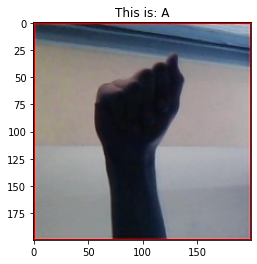

In [9]:
plt.imshow(images[0])
plt.title("This is: " + imageLabel[0])

In [10]:
# class Labels:
print("This are the class labels: ", classLabels)

This are the class labels:  ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [11]:
# split train and test images and also the class labels accordingly

X_train, X_test, y_train, y_test = train_test_split(images, imageLabel)

Text(0.5, 1.0, 'This is: E')

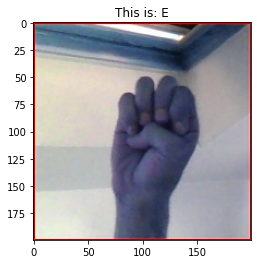

In [13]:
plt.imshow(X_train[0])
plt.title("This is: " + y_train[0])

In [14]:
# will normalize the images i.e., divide all the image pixel by 255
# will loop over all and divide the images / 255

for index in tqdm(range(0, len(X_train))):
  X_train[index] = X_train[index] / 255

for index in tqdm(range(0, len(X_test))):
  X_test[index] = X_test[index] / 255


100%|██████████| 363/363 [00:00<00:00, 1703.44it/s]


## Design the Model: VGG16

Using Transfer Learning of Imagenet weights (VGG16 has proved to be 92.7% accuracte with Imagenet dataset)



In [15]:
nos_of_Classes = len(classLabels)

image_input = tf.keras.Input(shape=(200, 200, 3))

vggModel = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input
)

In [16]:
vggModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [17]:
for layer in vggModel.layers:
    layer.trainable = False

In [18]:
base_model1 = keras.Sequential()
base_model1.add(vggModel)

In [19]:
x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Dropout(0.2)(x1)

In [20]:
x1

<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dropout')>

### OpenPose

In [21]:
input_ = layers.Input((200, 200, 3), name='image')

def main_block(input_, padding='same'):
    x = Conv2D(64, (3,3), strides=(1,1), padding=padding, name='conv1_1', activation='relu')(input_)
    x = Conv2D(64, (3,3), strides=(1,1), padding=padding, name='conv1_2', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool1_stage1')(x)

    x = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv2_1', activation='relu')(x)
    x = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv2_2', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool2_stage1')(x)

    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_1', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_2', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_3', activation='relu')(x)
    x = Conv2D(256, (3,3), strides=(1,1), padding=padding, name='conv3_4', activation='relu')(x)
    x = MaxPool2D((2,2), strides=(2,2), name='pool3_stage1')(x)

    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_1', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_2', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_3', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv4_4', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv5_1', activation='relu')(x)
    x = Conv2D(512, (3,3), strides=(1,1), padding=padding, name='conv5_2', activation='relu')(x)
    conv5_3_CPM = Conv2D(128, (3,3), strides=(1,1), padding=padding, name='conv5_3_CPM', activation='relu')(x)
    x = Conv2D(512, (1,1), strides=(1,1), padding='valid', name='conv6_1_CPM', activation='relu')(conv5_3_CPM)
    conv6_2_CPM = Conv2D(22, (1,1), padding='valid', strides=(1,1), name='conv6_2_CPM')(x)
    return conv5_3_CPM, conv6_2_CPM

conv5_3_CPM, conv6_2_CPM = main_block(input_)

def stage_block(conv5_3_CPM, prev_stage, stage, padding='same'):
    x = concatenate([ prev_stage, conv5_3_CPM ], axis=3, name='concat_stage{}'.format(stage))
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv1_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv2_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv3_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv4_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (7,7), strides=(1,1), padding=padding, name='Mconv5_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(128, (1,1), strides=(1,1), padding='valid', name='Mconv6_stage{}'.format(stage), activation='relu')(x)
    x = Conv2D(22, (1,1), strides=(1,1), padding='valid', name='Mconv7_stage{}'.format(stage))(x)
    return x
    
prev_stage = conv6_2_CPM
for stage in range(2, 7):
    prev_stage = stage_block(conv5_3_CPM, prev_stage, stage)
    
x = prev_stage
openPoseModel = models.Model(input_, x)

In [22]:
openPoseModel.output

<KerasTensor: shape=(None, 25, 25, 22) dtype=float32 (created by layer 'Mconv7_stage6')>

In [23]:
openPoseModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 200, 200, 64) 1792        image[0][0]                      
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 200, 200, 64) 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1_stage1 (MaxPooling2D)     (None, 100, 100, 64) 0           conv1_2[0][0]                    
______________________________________________________________________________________________

In [24]:
# openPoseModel.load_weights('drive/My Drive/ML Project NITT/openpose_hand_keras.h5')

In [25]:
# def featureExtractOpenPose(model, image_orig, scale_mul=2, peaks_th=0.1, sigma=3, mode='heatmap'):
    
#     scale = 368/image_orig.shape[1]
#     scale = scale*scale_mul
#     image =  cv2.resize(image_orig, (0,0), fx=scale, fy=scale) 
#     net_out = model.predict(np.expand_dims( image ,0))

#     return net_out

In [26]:
# Build tabular model
base_model2 = keras.Sequential()
base_model2.add(openPoseModel)
base_model2.add(Dense(12, activation='relu'))
base_model2.add(Dropout(0.2))
base_model2.add(Dense(8, activation='relu'))
base_model2.add(Dropout(0.2))
base_model2.add(Dense(nos_of_Classes, activation='softmax'))
base_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
base_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25, 25, 22)        36832324  
_________________________________________________________________
dense (Dense)                (None, 25, 25, 12)        276       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 12)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 25, 25, 8)         104       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 8)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 25, 25, 29)        261       
Total params: 36,832,965
Trainable params: 36,832,965
Non-trainable params: 0
__________________________________________

In [28]:
base_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25, 25, 22)        36832324  
_________________________________________________________________
dense (Dense)                (None, 25, 25, 12)        276       
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 12)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 25, 25, 8)         104       
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 25, 8)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 25, 25, 29)        261       
Total params: 36,832,965
Trainable params: 36,832,965
Non-trainable params: 0
__________________________________________

In [29]:
x2 = base_model2.output

In [30]:
x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)
x2 = Dropout(0.2)(x2)

In [31]:
x2

<KerasTensor: shape=(None, 29) dtype=float32 (created by layer 'dropout_3')>

In [32]:
# LATE FUSION
fusedModel = concatenate([x1, x2])
fusedModel = keras.Sequential()(fusedModel)
fusedModel = Dense(512, activation='relu')(fusedModel) #12
fusedModel = Dropout(0.2)(fusedModel)
fusedModel = Dense(512, activation='relu')(fusedModel) #8
fusedModel = Dropout(0.2)(fusedModel)
predictions = Dense(nos_of_Classes, activation='softmax')(fusedModel)

In [33]:
model = models.Model(inputs=[base_model1.input, base_model2.input], outputs=predictions)

In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

In [37]:
# converting string labels to interger labels

def stringMapInt(y):

  classLabelsDict = {}
  value = 0
  for label in classLabels:
    classLabelsDict[label] = value
    value = value + 1
  
  y_data = []

  for label in tqdm(y):
    y_data.append(classLabelsDict[label])
  
  return y_data


In [38]:
# One Hot Encoding for the classLabels

y_train_Label = stringMapInt(y_train)
y_test_Label = stringMapInt(y_test)

100%|██████████| 363/363 [00:00<00:00, 646236.14it/s]


In [39]:
y_train_oneHotEncoding = to_categorical(y_train_Label, num_classes=nos_of_Classes)
y_test_oneHotEncoding = to_categorical(y_test_Label, num_classes=nos_of_Classes)

In [40]:
y_train_oneHotEncoding

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
train_generator = datagen.flow([array(X_train),array(X_train)], y_train_oneHotEncoding, batch_size=32)
validation_generator = datagen.flow([array(X_test),array(X_test)], y_test_oneHotEncoding, batch_size=16)

In [42]:
# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor='val_loss',
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=2,
#         verbose=1)
# ]

# filepath = '/content/featureFusionModel.hdf5'
filepath = '/content/featureFusionModel.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [43]:
epochs = 50

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) / 32,
    epochs=epochs,
    validation_data=validation_generator,
    # callbacks=[model_checkpoint_callback]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
33/33 [==============================] - 78s 2s/step - loss: 3.4869 - accuracy: 0.0344 - val_loss: 3.3386 - val_accuracy: 0.0165
Epoch 2/50
33/33 [==============================] - 28s 813ms/step - loss: 3.3206 - accuracy: 0.0683 - val_loss: 3.2247 - val_accuracy: 0.0689
Epoch 3/50
33/33 [==============================] - 27s 802ms/step - loss: 3.1350 - accuracy: 0.1566 - val_loss: 2.8658 - val_accuracy: 0.2121
Epoch 4/50
33/33 [==============================] - 28s 810ms/step - loss: 2.8253 - accuracy: 0.2206 - val_loss: 2.3322 - val_accuracy: 0.4325
Epoch 5/50
33/33 [==============================] - 27s 803ms/step - loss: 2.3511 - accuracy: 0.3470 - val_loss: 1.9077 - val_accuracy: 0.4959
Epoch 6/50
33/33 [==============================] - 27s 799ms/step - loss: 1.9538 - accuracy: 0.4533 - val_loss: 1.4967 - val_accuracy: 0.6061
Epoch 7/50
33/33 [==============================] - 27s 796ms/step - loss: 1.6739 - accuracy: 0.5354 - val_loss: 1.3149 - val_accuracy: 0.6088
Ep

In [44]:
# model.load(filepath)

In [45]:
# model = tf.keras.models.load_model(filepath)

In [46]:
# y_test_Label - This is validation labels
y_valTest_prob = model.predict([np.array(X_test), np.array(X_test)])

In [47]:
y_valTest_predcited = y_valTest_prob.argmax(axis=-1)

In [48]:
print(y_test_Label)
print(y_valTest_predcited)

[2, 15, 25, 10, 14, 0, 7, 0, 25, 8, 9, 17, 17, 11, 12, 28, 27, 19, 8, 21, 1, 4, 25, 15, 15, 18, 16, 20, 23, 13, 15, 27, 25, 20, 23, 8, 19, 17, 21, 28, 22, 0, 7, 26, 27, 18, 1, 7, 8, 14, 6, 18, 20, 0, 5, 15, 12, 26, 13, 5, 23, 23, 7, 15, 18, 18, 2, 21, 14, 2, 4, 22, 20, 14, 8, 7, 26, 2, 27, 3, 4, 2, 6, 12, 2, 25, 24, 27, 8, 27, 6, 12, 10, 20, 13, 13, 23, 13, 9, 18, 26, 16, 21, 8, 8, 12, 12, 24, 1, 15, 3, 15, 13, 3, 17, 8, 16, 28, 10, 5, 5, 0, 15, 12, 10, 2, 0, 21, 4, 4, 9, 23, 28, 16, 8, 22, 13, 26, 9, 5, 17, 16, 28, 22, 4, 18, 13, 25, 8, 10, 3, 0, 23, 14, 2, 25, 20, 23, 19, 28, 8, 17, 12, 25, 20, 27, 3, 15, 7, 19, 19, 28, 17, 6, 5, 24, 4, 26, 19, 23, 12, 9, 27, 12, 20, 21, 22, 24, 5, 9, 8, 13, 13, 11, 23, 3, 12, 11, 2, 20, 17, 9, 24, 1, 22, 11, 4, 12, 22, 1, 6, 6, 6, 12, 19, 9, 22, 3, 19, 4, 23, 12, 26, 11, 18, 17, 22, 15, 7, 7, 21, 25, 21, 27, 15, 24, 14, 9, 7, 4, 26, 24, 25, 14, 9, 12, 5, 23, 21, 18, 27, 20, 28, 20, 27, 18, 9, 16, 22, 8, 9, 23, 7, 17, 16, 18, 2, 26, 17, 25, 18, 24, 1

In [50]:
# Accuracy Score for Validation Test and predicted test labels
accuracy_score(y_test_Label, y_valTest_predcited)

0.9696969696969697

In [51]:
cmVT = confusion_matrix(y_test_Label, y_valTest_predcited)

In [52]:
df_cmVT = pd.DataFrame(cmVT, index = classLabels, columns = classLabels)

In [53]:
df_cmVT

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,del,nothing,space
A,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
D,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


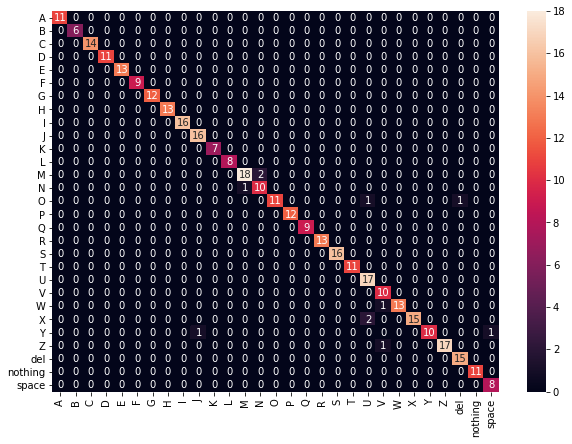

In [54]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cmVT, annot=True)

In [55]:
# F1 Score

f1_score(y_test_Label, y_valTest_predcited, average='macro')

0.972307463944698

In [56]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nos_of_Classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oneHotEncoding[:, i], y_valTest_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_oneHotEncoding.ravel(), y_valTest_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

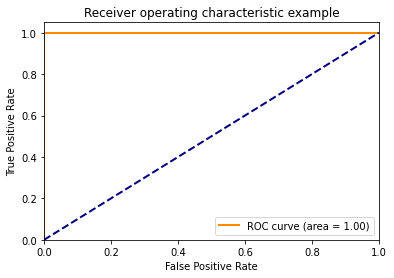

In [57]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [58]:
cmVT = confusion_matrix(y_test_Label, y_valTest_predcited)

In [59]:
import gc

# WOWOWOWW

In [60]:
del images
gc.collect()

2875

In [61]:
del X_train
gc.collect()

44

In [62]:
del X_test
gc.collect()

141

In [63]:
# def load_imagesTest(folderPath):
#   images = []
#   imageLabel = []

#   classLabels = []

#   for filename in tqdm(sorted(list(os.listdir(folderPath)))):
#     if '.DS_Store' not in filename:
#         img = cv2.imread(os.path.join(folderPath,filename))
#         if img is not None:
#             img = img/255
#             images.append(img)
#             imageLabel.append(filename.split('_')[0])
          
#   return images, imageLabel, classLabels

In [101]:
def load_imagesTest(folderPath):
  images = []
  imageLabel = []

  classLabels = []

  # using sorted to organise the foldernames in alphabetic order
  folderList = list(sorted(os.listdir(folderPath)))
  # print(folderList)
  for folderName in tqdm(folderList):
    k = 0
    m = 0
    if '.DS_Store' not in folderName:
      classLabels.append(folderName)
      subFolder = os.path.join(folderPath, folderName)
      for filename in (list(sorted(os.listdir(subFolder)))):
        if '.DS_Store' not in filename:
          img = cv2.imread(os.path.join(subFolder,filename))
          # img = img/255
          if img is not None and m > 40:
              img = img/255
              images.append(img)
              imageLabel.append(folderName)
              k = k + 1;
          m = m + 1    
          if k == 50:
            break
          

  return images, imageLabel, classLabels

In [102]:
testDatasetFolderPath = '/content/asl_alphabet_train/asl_alphabet_train/'

In [103]:
testImages, testImageLabel, testClassLabels = load_imagesTest(testDatasetFolderPath)

100%|██████████| 29/29 [00:02<00:00, 12.79it/s]


In [104]:
predictTestLabelsProb = model.predict([np.array(testImages),np.array(testImages)])

In [105]:
predictTestLabelsProb

array([[9.9896765e-01, 2.1539906e-06, 1.3515685e-09, ..., 5.7847616e-11,
        2.8876608e-11, 1.8123329e-11],
       [9.9900514e-01, 2.7456936e-06, 1.9096840e-09, ..., 5.5520064e-11,
        2.9665988e-11, 2.7130409e-11],
       [9.9902260e-01, 4.9362461e-07, 1.5592785e-09, ..., 5.0507952e-11,
        7.7941065e-12, 5.8530167e-11],
       ...,
       [2.6320138e-06, 1.1234756e-06, 5.8627051e-05, ..., 1.6895061e-03,
        2.1735619e-07, 1.3163195e-02],
       [9.4586967e-06, 1.5899898e-06, 7.3594354e-05, ..., 2.1845759e-03,
        2.0660143e-07, 1.2594101e-02],
       [1.3531512e-10, 1.1334292e-09, 4.0611794e-06, ..., 6.7321603e-06,
        5.3365045e-11, 9.9977559e-01]], dtype=float32)

In [106]:
y_classesPredicted = predictTestLabelsProb.argmax(axis=-1)

In [107]:

y_classes = []

for i in testImageLabel:
  if(i in classLabels):
    y_classes.append(classLabels.index(i))

In [108]:
print(y_classes)
print(y_classesPredicted[0:20])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [109]:
accuracy_score(y_classes, y_classesPredicted)

0.7572413793103449

In [110]:
cm = confusion_matrix(y_classes, y_classesPredicted)

In [111]:
df_cm = pd.DataFrame(cm, index = classLabels, columns = classLabels)

In [112]:
df_cm

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,del,nothing,space
A,33,0,0,0,0,0,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C,0,1,44,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1
D,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
E,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,28,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
I,0,0,0,8,0,0,0,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


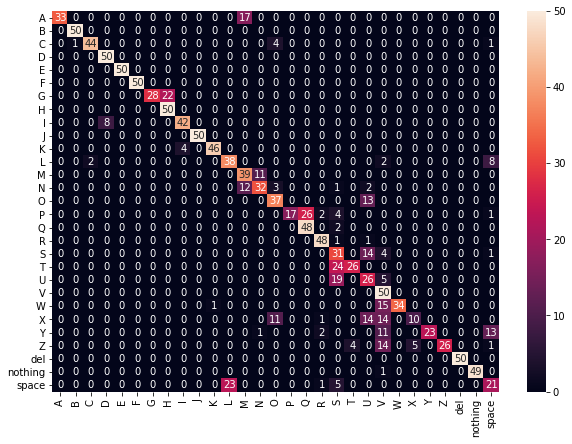

In [113]:
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [114]:
# F1 Score

f1_score(y_classes, y_classesPredicted, average='macro')

0.7559398234253207

In [115]:
y_test_Encoding = to_categorical(y_classes, num_classes=nos_of_Classes)

In [116]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nos_of_Classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_Encoding[:, i], predictTestLabelsProb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_Encoding.ravel(), predictTestLabelsProb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

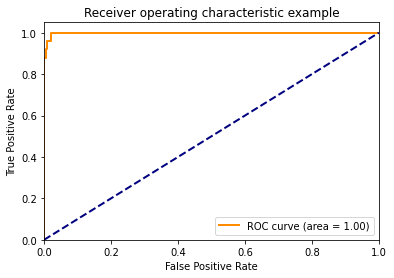

In [117]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [100]:
del testImages
gc.collect()

2494